In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 08 - Simple Neural Network with Fibonacci 

### v1 mean_absolute_error-prediction

by Louis Yang

Recheck the peformance of model 04 with the grouping and Fibonacci median

Use Fibonacci series median instead of median

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained ANN as prediction.

Modified from the "model_7_CNN_with_Fibonacci_2_Mix"

Result: 

In [2]:
model_name = 'model_8_ANN_with_Fibonacci_1_meas_absolute_error-prediction'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

In [4]:
def arr_info(arr_list):
    print('shape, min, max, median, stdev')
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

## Input

In [5]:
print('%%% Reading data train_1.csv ... ', end = '', flush = True)
input_df = pd.read_csv("../data/train_1.csv")
print('done!')

%%% Reading data train_1.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

input_data = input_df[input_df_dates].values; input_data

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
test_length = 0  # for predicting
#test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [193]:
daydiff(input_df_dates[0], input_df_dates[-364-63])

datetime.timedelta(-123)

In [10]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [11]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2015-11-01', '2016-01-02')

In [12]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [13]:
# X for output set
if test_length:
    print('Testing')
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    print('Predicting')
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

Predicting


In [14]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2016-10-30', '2016-12-31')

In [15]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [16]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Both are Wednesday (2).

#### Y

In [17]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [18]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-01-03', '2016-03-05')

In [19]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [20]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-01-01'
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [21]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-01-01', '2017-03-04')

In [22]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [23]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Both are Sunday (6).

## Fibonacci

In this testing code, we should not include the last y_length days since in the real predicting stage, we don't know their visits.

Here, we don't distinguish between input and output fib_dates.

In [24]:
if test_length:
    fib_dates = input_df_dates[:-test_length]
else:
    fib_dates = input_df_dates
fib_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [25]:
fib_data = input_df[fib_dates].values; fib_data

array([[ 18.,  11.,   5., ...,  19.,  18.,  20.],
       [ 11.,  14.,  15., ...,  45.,  26.,  20.],
       [  1.,   0.,   1., ...,   3.,   4.,  17.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

### Find starting dates

Not using this. Use numpy nan method instead

start_tf = ~np.isnan(fib_data); start_tf

fib_days = len(fib_data[0]); fib_days

index_range = np.arange(fib_days)
def first_true_index(x):
    temp = index_range[x]
    if temp.any():
        return temp[0]
    else:
        return -1
#first_true_index_v = np.vectorize(first_true_index)

start_index = np.array([first_true_index(x) for x in start_tf])

start_index

### Window

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [26]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]

In [27]:
fib_view_list = [fib_data[:, -w:] for w in windows]

In [28]:
fib_median_list = np.array([np.nanmedian(view, axis=-1) 
                            for view in fib_view_list])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [29]:
fib_median_list.T.shape

(145063, 8)

In [30]:
fib_median_na = np.nanmedian(fib_median_list.T, axis=-1)

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_median_na

In [31]:
fib_median = np.nan_to_num(fib_median_na); fib_median.shape

(145063,)

In [32]:
fib_median

array([ 18.25,  21.5 ,   4.  , ...,   0.  ,   0.  ,   0.  ])

We will use this as the center and part of the result

In [33]:
Y_output_fib = fib_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

In [34]:
X_input_first_day, Y_input_final_day

('2015-11-01', '2016-03-05')

input_data contains X_input and Y_input array

In [35]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates

Index(['2015-11-01', '2015-11-02', '2015-11-03', '2015-11-04', '2015-11-05',
       '2015-11-06', '2015-11-07', '2015-11-08', '2015-11-09', '2015-11-10',
       ...
       '2016-02-25', '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
       '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05'],
      dtype='object', length=126)

In [36]:
input_data = input_df[input_dates].values; input_data

array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
       [ 11.,  14.,  14., ...,  26.,  16.,  16.],
       [  6.,   2.,   5., ...,   1.,   4.,   7.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

##### Convert nan to number 0.

In [37]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[ 24.,   6.,   6., ...,  15.,   5.,  21.],
       [ 11.,  14.,  14., ...,  26.,  16.,  16.],
       [  6.,   2.,   5., ...,   1.,   4.,   7.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [38]:
input_data_num.shape

(145063, 126)

### Output Data

In [39]:
X_output_first_day, X_output_final_day, Y_output_final_day

('2016-10-30', '2016-12-31', '2017-03-04')

output_data for this self-testing script contains both X_output and Y_output

In [40]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates

Index(['2016-10-30', '2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03',
       '2016-11-04', '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
       '2016-11-09', '2016-11-10', '2016-11-11', '2016-11-12', '2016-11-13',
       '2016-11-14', '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
       '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
       '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
       '2016-11-29', '2016-11-30', '2016-12-01', '2016-12-02', '2016-12-03',
       '2016-12-04', '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
       '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
       '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-18',
       '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
       '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
       '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object')

In [41]:
output_dates.shape

(63,)

In [42]:
output_data = input_df[output_dates].values; output_data

array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
       [ 15.,  24.,  13., ...,  45.,  26.,  20.],
       [  2.,   6.,   1., ...,   3.,   4.,  17.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

##### Convert nan to number 0.

In [43]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 50.,  16.,  30., ...,  19.,  18.,  20.],
       [ 15.,  24.,  13., ...,  45.,  26.,  20.],
       [  2.,   6.,   1., ...,   3.,   4.,  17.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [44]:
output_data_num.shape

(145063, 63)

### View

In [45]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [46]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [47]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [48]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [49]:
output_data_log.shape, output_data.shape

((145063, 63), (145063, 63))

input_data_log

output_data_log

#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [50]:
gc.collect()

0

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [51]:
input_center = log(fib_median).reshape(-1,1)
output_center = log(fib_median).reshape(-1,1)

In [52]:
input_center

array([[ 1.28443073],
       [ 1.35218252],
       [ 0.69897   ],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

#### Compute Median and Stdev

Here we are not using this median

In [53]:
np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)

array([[ 1.20411998],
       [ 1.14612804],
       [ 0.60205999],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [54]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = 1.0  # Prevent divid by zero
input_scale  # remember sample-wised scale

array([[ 0.28698004],
       [ 0.24215417],
       [ 0.19345186],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [55]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = 1.0  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.25058444],
       [ 0.27659201],
       [ 0.30125919],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [56]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [57]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [58]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

#### Input Center

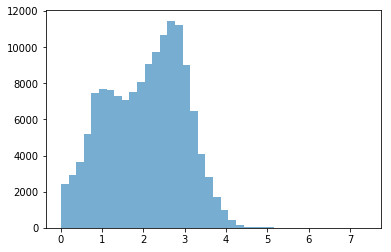

In [59]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.show()

plt.hist(input_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Center

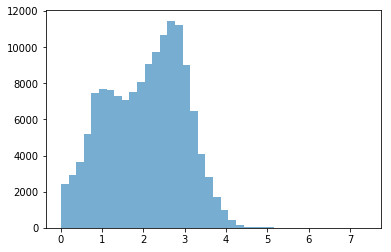

In [60]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.show()

plt.hist(output_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Input Scale

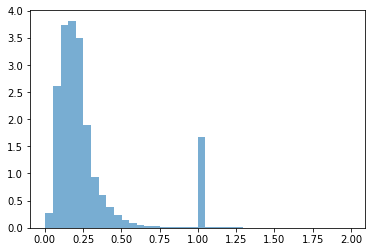

In [61]:
plt.hist(input_scale, bins=40, normed=True, alpha=0.6)
plt.show()

plt.hist(input_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Scale

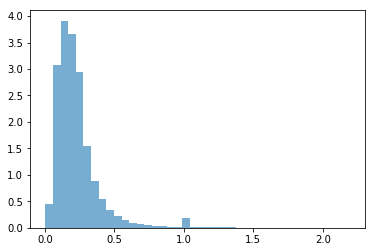

In [62]:
plt.hist(output_scale, bins=40, normed=True, alpha=0.6)
plt.show()

plt.hist(output_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [63]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [64]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
input_gp, output_gp

(array([2, 2, 1, ..., 0, 0, 0]), array([2, 2, 1, ..., 0, 0, 0]))

In [65]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[2291, 22088, 41343, 78354, 927, 60]

In [66]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[2291, 22088, 41343, 78354, 927, 60]

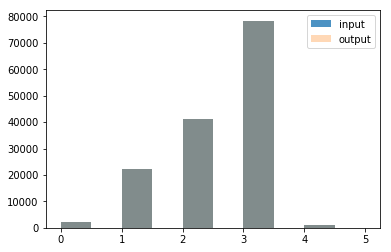

In [67]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

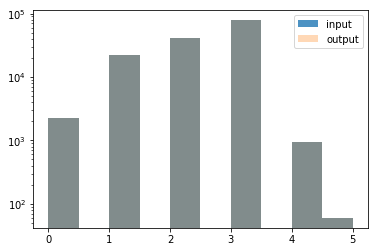

In [68]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.6)
plt.yscale('log')
plt.show()

plt.hist(output_gp, alpha=0.6)
plt.yscale('log')
plt.show()

## Make (X,Y) pairs data from data set

day_shift = 0

def make_XY(data, x_length=x_length, y_length=y_length, shift=day_shift):
    if shift == 0:
        return data[:, -x_length-y_length:-y_length], data[:, -y_length:]
    else:
        return data[:, -x_length-y_length-shift:-y_length-shift], data[:, -y_length-shift:-shift]

In [69]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [70]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) No Y_output


#### Original data

In [71]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [72]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

In [73]:
X_train = X_input
Y_train = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

In [74]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

In [75]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

#### Min and max cases examination

np.argmax(Y_input, axis=0)

Y_input[34790]

Y_input_ori[34790]

fib_median[34790]

log(Y_input_ori[34790])

log(fib_median[34790])

np.std(log(Y_input_ori[34790]))

np.std(log(X_input_ori[34790]))

input_scale[34790]

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [76]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [77]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [78]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(),
                                            None))
    return 200. * K.mean(diff, axis=-1)

In [79]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), K.epsilon(),
                          None))
    return 200. * np.nanmean(diff, axis=axis)

def smape_CPMP(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error suggested by CPMP'''
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff, axis=axis)

In [80]:
smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

(200.0, 0.0)

smape_CPMP(np.array([0,1]),np.array([np.nan, 0])), smape_CPMP(np.array([0]),np.array([0]))

#Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

In [81]:
# Benchmark SMAPE on the original data
smape(Y_input_raw[:,:x_length],X_input_ori[:,-y_length:]), smape(Y_input_ori[:,:x_length],X_input_ori[:,-y_length:])

(58.879528613927789, 54.623816383048805)

Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [82]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D

In [83]:
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Dense(120, activation='relu')(layer_0)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_absolute_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               7680      
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               14520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 63)                7623      
T

#CNN
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(120, kernel_size=5, activation='relu')(layer_t)
    layer_t = MaxPooling1D(pool_size=2)(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_squared_error', metrics=[k_smape])
    model.summary()
    models.append(model)

In [84]:
len(gp_list)

6

In [85]:
epochs_list = [40,40,40,40,60,80]

In [86]:
%%time
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    print('Group:',gp)
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05, verbose=2)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Group: 0
Train on 2176 samples, validate on 115 samples
Epoch 1/40
1s - loss: 0.7833 - k_smape: 185.6840 - val_loss: 0.2326 - val_k_smape: 193.8338
Epoch 2/40
0s - loss: 0.7021 - k_smape: 190.8314 - val_loss: 0.1804 - val_k_smape: 192.5492
Epoch 3/40
0s - loss: 0.6609 - k_smape: 191.0593 - val_loss: 0.1694 - val_k_smape: 192.7763
Epoch 4/40
0s - loss: 0.6356 - k_smape: 192.5734 - val_loss: 0.1688 - val_k_smape: 192.9454
Epoch 5/40
0s - loss: 0.6328 - k_smape: 192.6950 - val_loss: 0.1480 - val_k_smape: 192.0403
Epoch 6/40
0s - loss: 0.6243 - k_smape: 191.7335 - val_loss: 0.1544 - val_k_smape: 192.8100
Epoch 7/40
0s - loss: 0.6162 - k_smape: 192.3653 - val_loss: 0.1348 - val_k_smape: 192.1210
Epoch 8/40
0s - loss: 0.6156 - k_smape: 192.1172 - val_loss: 0.1491 - val_k_smape: 192.5183
Epoch 9/40
0s - loss: 0.6089 - k_smape: 190.8594 - val_loss: 0.1334 - val_k_smape: 192.1020
Epoch 10/40
0s - loss: 0.6210 - k_smape: 192.4218 - val_loss: 0.1541 - val_k_smape: 192.5932
Epoch 11/40
0s - loss: 

1s - loss: 1.0112 - k_smape: 108.4873 - val_loss: 0.9073 - val_k_smape: 132.7358
Epoch 9/40
1s - loss: 1.0098 - k_smape: 108.3413 - val_loss: 0.9118 - val_k_smape: 133.6934
Epoch 10/40
1s - loss: 1.0122 - k_smape: 108.1864 - val_loss: 0.9114 - val_k_smape: 134.9625
Epoch 11/40
1s - loss: 1.0078 - k_smape: 107.7505 - val_loss: 0.9115 - val_k_smape: 133.2389
Epoch 12/40
1s - loss: 1.0073 - k_smape: 107.5727 - val_loss: 0.9105 - val_k_smape: 132.7718
Epoch 13/40
1s - loss: 1.0035 - k_smape: 107.0760 - val_loss: 0.9074 - val_k_smape: 131.7977
Epoch 14/40
1s - loss: 1.0015 - k_smape: 106.8905 - val_loss: 0.9055 - val_k_smape: 131.7845
Epoch 15/40
1s - loss: 0.9998 - k_smape: 106.7642 - val_loss: 0.9056 - val_k_smape: 130.9967
Epoch 16/40
1s - loss: 0.9967 - k_smape: 106.5129 - val_loss: 0.9113 - val_k_smape: 131.4639
Epoch 17/40
1s - loss: 0.9976 - k_smape: 106.2362 - val_loss: 0.9085 - val_k_smape: 131.4096
Epoch 18/40
1s - loss: 0.9988 - k_smape: 106.2305 - val_loss: 0.9105 - val_k_smape:

0s - loss: 1.3189 - k_smape: 88.8786 - val_loss: 0.9191 - val_k_smape: 88.1689
Epoch 21/60
0s - loss: 1.2809 - k_smape: 85.4984 - val_loss: 0.9769 - val_k_smape: 91.0560
Epoch 22/60
0s - loss: 1.2643 - k_smape: 87.2536 - val_loss: 1.0365 - val_k_smape: 88.7318
Epoch 23/60
0s - loss: 1.2460 - k_smape: 84.3928 - val_loss: 1.1063 - val_k_smape: 93.1414
Epoch 24/60
0s - loss: 1.2875 - k_smape: 86.3732 - val_loss: 1.0959 - val_k_smape: 92.6046
Epoch 25/60
0s - loss: 1.3071 - k_smape: 85.4170 - val_loss: 1.0849 - val_k_smape: 94.1922
Epoch 26/60
0s - loss: 1.2654 - k_smape: 83.3066 - val_loss: 1.0120 - val_k_smape: 87.2014
Epoch 27/60
0s - loss: 1.2242 - k_smape: 81.7412 - val_loss: 0.9169 - val_k_smape: 89.1896
Epoch 28/60
0s - loss: 1.2102 - k_smape: 82.5982 - val_loss: 0.8869 - val_k_smape: 85.0371
Epoch 29/60
0s - loss: 1.2700 - k_smape: 81.9722 - val_loss: 0.9092 - val_k_smape: 85.1357
Epoch 30/60
0s - loss: 1.2360 - k_smape: 81.3046 - val_loss: 0.8596 - val_k_smape: 83.3866
Epoch 31/60

### Training History

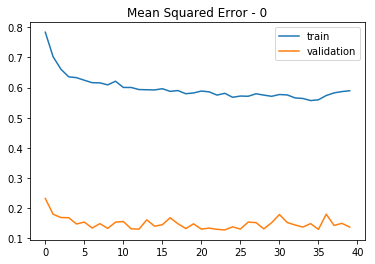

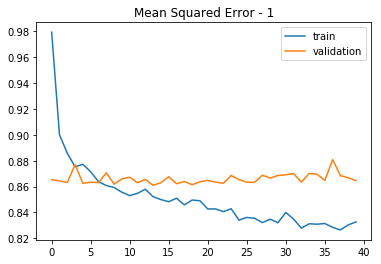

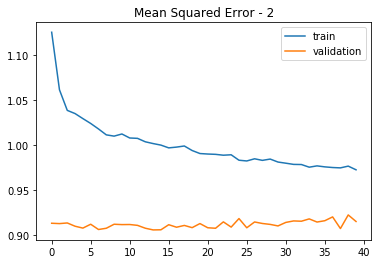

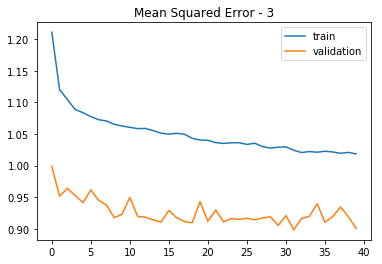

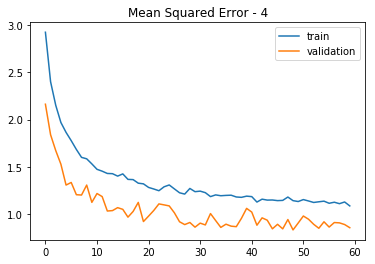

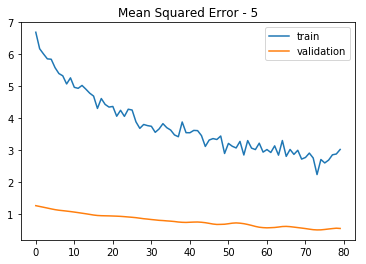

In [87]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

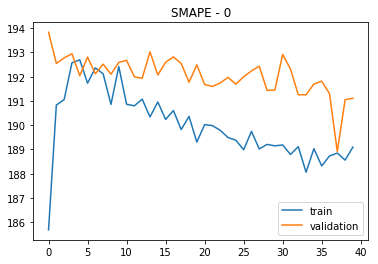

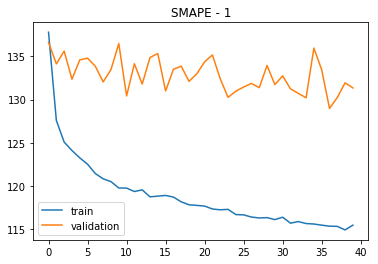

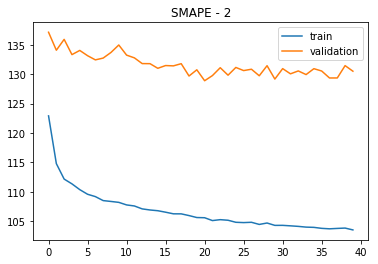

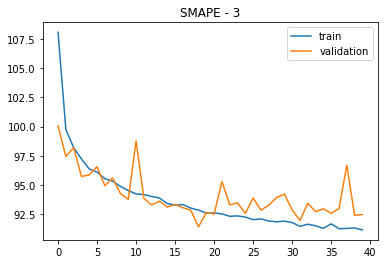

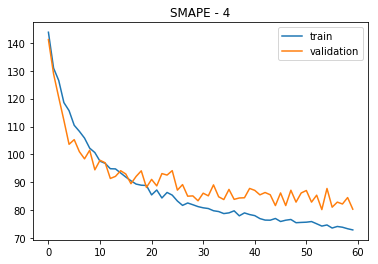

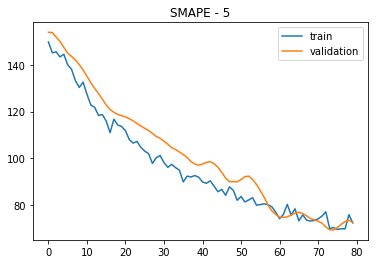

In [88]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

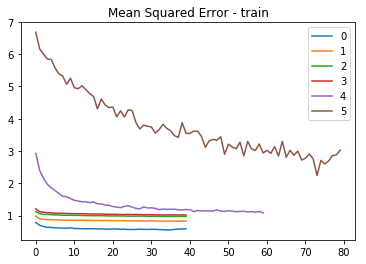

In [89]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

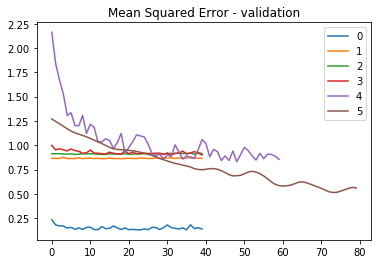

In [90]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

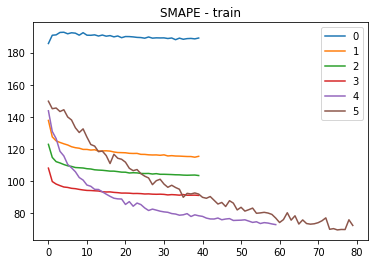

In [91]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

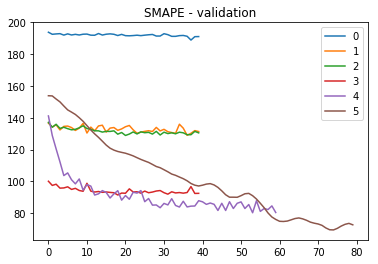

In [92]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Input Set

In [93]:
if test_length == 0:
    Y_input_pred_list = []
    for (gp, model, X) in zip(gp_list, models, X_input_list):
        print(gp)
        Y_input_pred_list.append(model.predict(X))

0
1
2
3
4
5


In [94]:
if test_length == 0:
    input_index_range = np.arange(len(input_gp)); input_index_range

    # list for original index
    input_index_list = [input_index_range[input_gp == gp] 
                         for gp in gp_list]

    for i in input_index_list:
        print(i.shape)

    input_index_list_comb = np.concatenate(input_index_list)
    print(input_index_list_comb)

    Y_input_pred_comb = np.concatenate(Y_input_pred_list)

    Y_input_pred_temp = [0]*len(input_index_list_comb)
    for index, y in zip(input_index_list_comb, Y_input_pred_comb):
        Y_input_pred_temp[index] = y
    Y_input_pred = np.array(Y_input_pred_temp)

    # Inverse transform Y of input
    Y_input_pred_ori = unlog(untransform(Y_input_pred, 
                                         input_center, input_scale))

(2291,)
(22088,)
(41343,)
(78354,)
(927,)
(60,)
[    54    117    148 ..., 123025 139119 140151]


### Evaluation using for Output Set

In [95]:
if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))

### Predict for Output Set

In [96]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4
5


Find the original index

In [97]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [98]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [99]:
for o in output_index_list:
    print(o.shape)

(2291,)
(22088,)
(41343,)
(78354,)
(927,)
(60,)


In [100]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([    54,    117,    148, ..., 123025, 139119, 140151])

In [101]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [102]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)

In [103]:
# Inverse transform Y of output
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

#### Check predict output

In [104]:
Y_output_pred

array([[  5.20530045e-01,   4.98070955e-01,   5.01036823e-01, ...,
          3.51502597e-01,   3.69337261e-01,   3.99777144e-01],
       [ -2.06557810e-01,  -1.74912572e-01,  -1.65831923e-01, ...,
         -1.93121359e-01,  -1.77608550e-01,  -1.29812524e-01],
       [  9.41635370e-02,   2.40665913e-01,   3.08469623e-01, ...,
          3.00027460e-01,   2.97410190e-01,   2.38200963e-01],
       ..., 
       [  1.87878744e-04,   7.70395418e-05,   9.60903562e-05, ...,
          3.32095631e-04,   1.16546995e-04,   1.86210367e-04],
       [  1.87878744e-04,   7.70395418e-05,   9.60903562e-05, ...,
          3.32095631e-04,   1.16546995e-04,   1.86210367e-04],
       [  1.87878744e-04,   7.70395418e-05,   9.60903562e-05, ...,
          3.32095631e-04,   1.16546995e-04,   1.86210367e-04]], dtype=float32)

In [105]:
Y_output_pred_ori

array([[  2.49936617e+01,   2.46589904e+01,   2.47029377e+01, ...,
          2.25782634e+01,   2.28221472e+01,   2.32442450e+01],
       [  1.87265110e+01,   1.91281147e+01,   1.92448579e+01, ...,
          1.88960422e+01,   1.90935843e+01,   1.97146410e+01],
       [  4.33749689e+00,   4.90843989e+00,   5.19297479e+00, ...,
          5.15681399e+00,   5.14564622e+00,   4.89834583e+00],
       ..., 
       [  4.32700384e-04,   1.77405835e-04,   2.21280701e-04, ...,
          7.64970891e-04,   2.68395385e-04,   4.28857149e-04],
       [  4.32700384e-04,   1.77405835e-04,   2.21280701e-04, ...,
          7.64970891e-04,   2.68395385e-04,   4.28857149e-04],
       [  4.32700384e-04,   1.77405835e-04,   2.21280701e-04, ...,
          7.64970891e-04,   2.68395385e-04,   4.28857149e-04]])

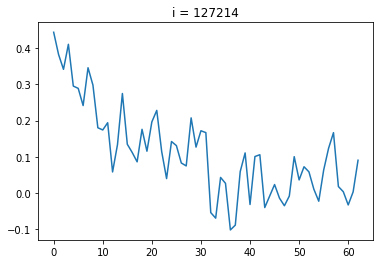

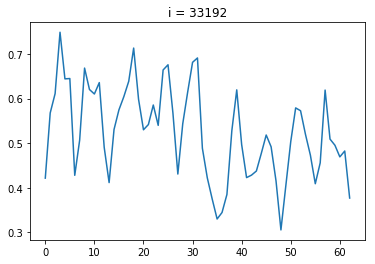

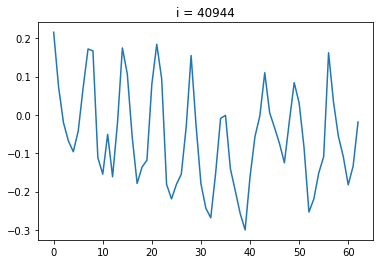

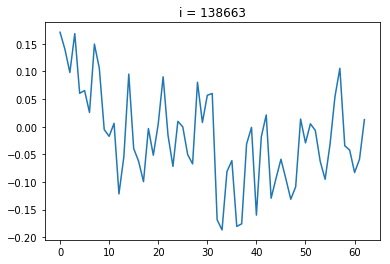

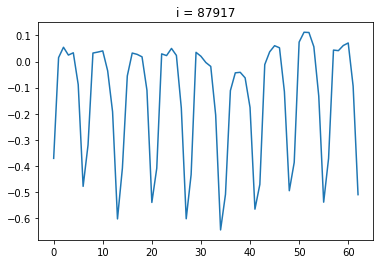

array([127214,  33192,  40944, 138663,  87917])

In [106]:
examine(Y_output_pred)

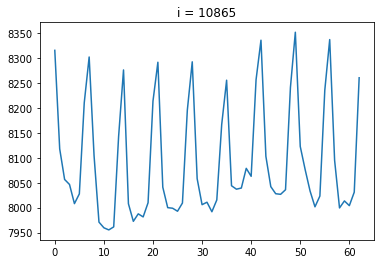

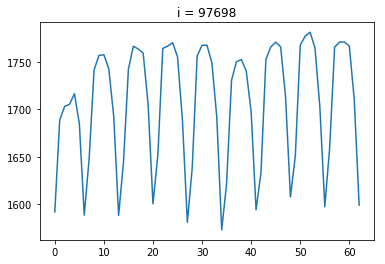

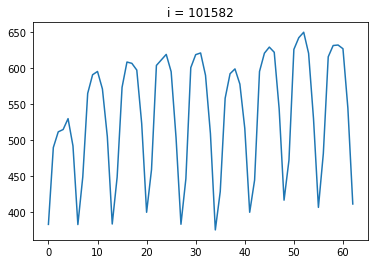

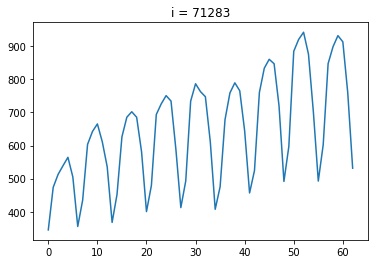

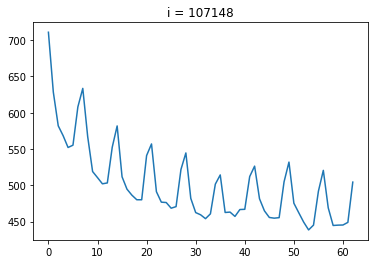

array([ 10865,  97698, 101582,  71283, 107148])

In [107]:
examine(Y_output_pred_ori)

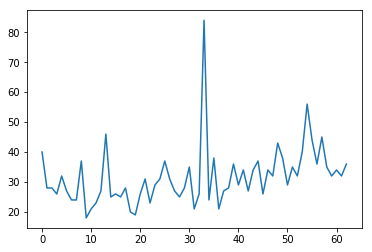

In [108]:
view(X_output_ori[126420])

## Self-Testing

In [109]:
# SMAPE assuming nan == 0
if test_length == 0: 
    model_smape_score_0 = smape(Y_input_ori, Y_input_pred_ori)
    print(model_smape_score_0)

51.5040258171


In [110]:
# SMAPE training score excluding nan (Correct one)
if test_length == 0: 
    model_smape_score = smape(Y_input_raw, Y_input_pred_ori)
    print(model_smape_score)

40.6171581111


In [111]:
# SMAPE assuming nan == 0
if test_length: 
    model_smape_score_0 = smape(Y_output_ori, Y_output_pred_ori)
    print(model_smape_score_0)

In [112]:
# SMAPE score excluding nan (Correct one)
if test_length: 
    model_smape_score = smape(Y_output_raw, Y_output_pred_ori)
    print(model_smape_score)

In [113]:
model_name

'model_8_ANN_with_Fibonacci_1_meas_absolute_error-prediction'

In [114]:
epochs_list#, epochs_list2

[40, 40, 40, 40, 60, 80]

## Group Scores
For self-testing stage only

In [115]:
# Prediction Y_output in group
Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]    

In [116]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [117]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [118]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

In [119]:
if test_length: print(count_not_nan(Y_output_raw))

In [120]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
                  in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape = [smape(Y, Y_p) for Y, Y_p 
                in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [121]:
if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape_score, '%6.2f' % model_smape_score_0)

In [122]:
if test_length:
    print(n_not_nan_gp)

if test_length:
    x_tmp = 0.
    for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
        s_tmp = smape(Y, Y_p) * len(Y)
        print(s_tmp / tot_n)
        x_tmp += s_tmp
    print('SMAPE(0):', '%6.2f' % (x_tmp / tot_n))

#the correct one (excluding nan)
n_not_nan = count_not_nan(Y_output_raw)
x_tmp = 0.
for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list):
    s_tmp = smape(Y, Y_p) * count_not_nan(Y)
    print(s_tmp / n_not_nan)
    x_tmp += s_tmp
x_tmp / n_not_nan

### For Prediction estimation using input set (training set)

In [123]:
# Prediction Y_input in group
if test_length == 0:
    Y_input_pred_ori_list = [Y_input_pred_ori[input_gp == gp] for gp in gp_list]    

In [124]:
# True Y_input in group
if test_length == 0:
    # untransformed Y_input with nan replaced by 0
    Y_input_ori_list = [Y_input_ori[input_gp == gp] for gp in gp_list]
    
    # untransformed Y_input_ori with nan (for SMAPE estimation)
    Y_input_raw_list = [Y_input_raw[input_gp == gp] for gp in gp_list]

In [125]:
tot_n_input = len(input_gp); tot_n_input  # total number of pages in input set

145063

In [126]:
print(count_not_nan(Y_input_raw))

8336041


In [127]:
# Group SMAPE scores
if test_length == 0:
    gp_n = [len(Y) for Y in Y_input_raw_list]
    # SMAPE assuming nan == 0
    gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
                  in zip(Y_input_ori_list, Y_input_pred_ori_list)]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape = [smape(Y, Y_p) for Y, Y_p 
                in zip(Y_input_raw_list, Y_input_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_input_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_input_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_input_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [128]:
if test_length == 0:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape_score, '%6.2f' % model_smape_score_0)

[Group SMAPE]
W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio
138.27 131.72          0.90   2291          0.374
 60.67  81.83          8.29  22088          0.819
 43.05  50.88         12.54  41343          0.932
 33.46  41.05         18.69  78354          0.943
 28.13  41.09          0.18    927          0.921
 39.94  58.61          0.02     60          0.883
-------------------------------------------------
 40.62  51.50


## Compare

In [129]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

In [130]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True, xlim=None, ylim=None, yscale='linear'):
    plt.yscale(yscale)
    for x in x_list:
        plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None, xlim=None, ylim=None, yscale='linear'):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i), xlim=xlim, ylim=ylim, yscale=yscale)
    return list(view_list)

view_list = None

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

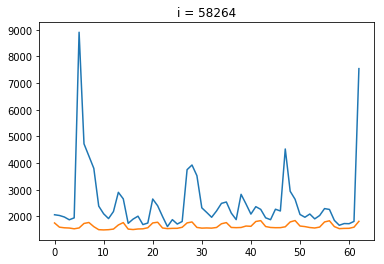

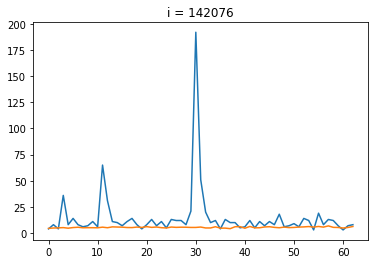

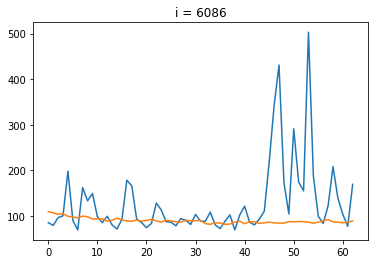

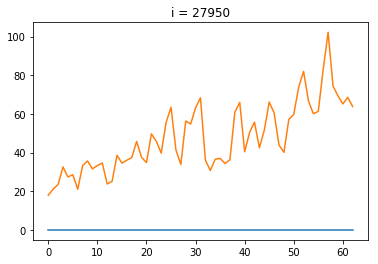

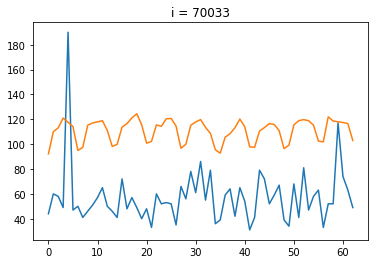

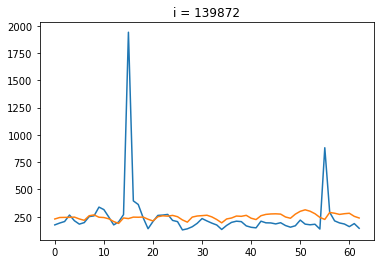

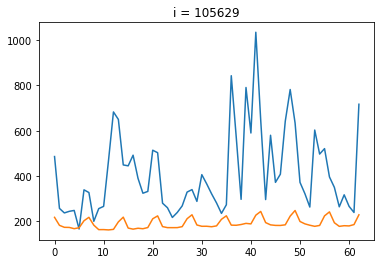

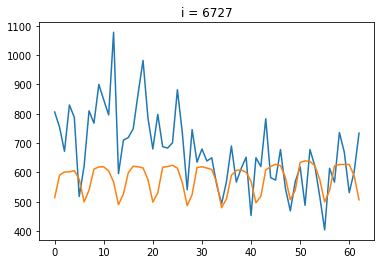

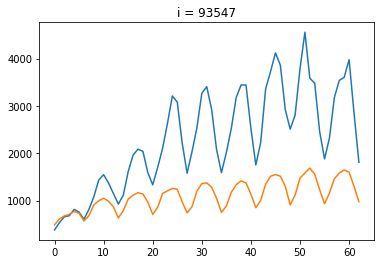

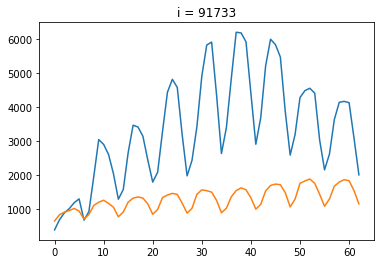

In [131]:
view_list = comp_examine(Y_input_ori, Y_output_pred_ori, view_list=view_list)

In [132]:
if test_length:
    view_list = comp_examine(Y_output_ori, Y_output_pred_ori, view_list=view_list)

In [133]:
if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output),
                             view_list=view_list)

In [134]:
if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
                             view_list=view_list)

comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

In [135]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

In [136]:
if test_length:
    view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]
else:
    view_list_smape = [np.nan_to_num(smape(Y_input_pred_ori[i], Y_input_raw[i])) for i in view_list]
view_list_smape

c:\python3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


[33.212275021469807,
 81.845816118684951,
 86.171264014491442,
 62.832103734251262,
 140.33940735162713,
 0.0,
 27.05675295761981,
 0.0,
 16.142997348603782,
 99.71713226284659]

In [137]:
view_list_review = [score < model_smape_score for score in view_list_smape]; view_list_review

[True, False, False, False, False, True, True, True, True, False]

In [138]:
view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

[93175, 64392, 73856, 140331, 19234]

In [139]:
view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

[13986, 5464, 89589, 119659, 25591]

#### Good cases

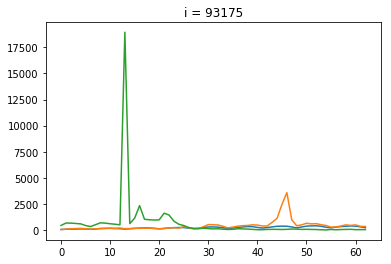

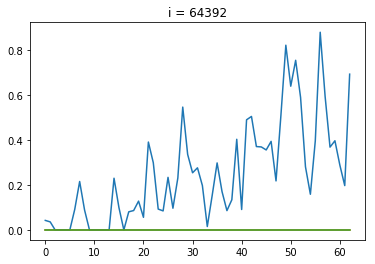

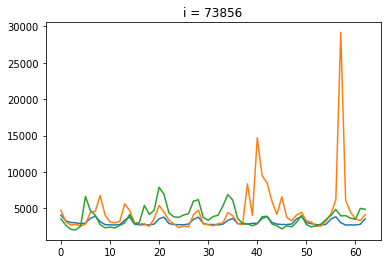

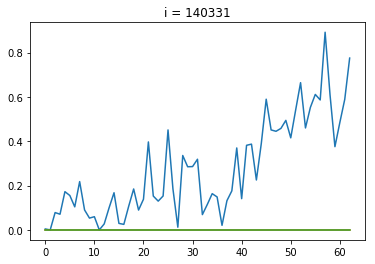

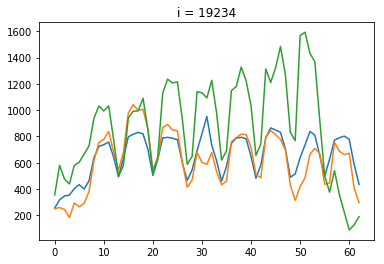

In [140]:
if test_length: examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list_good)
else:           examine_list((Y_input_pred_ori, Y_input_ori, X_input_ori), view_list=view_list_good)

#### Bad cases

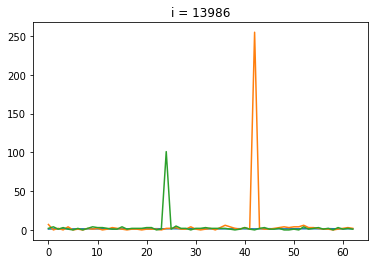

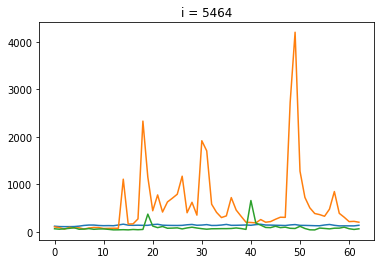

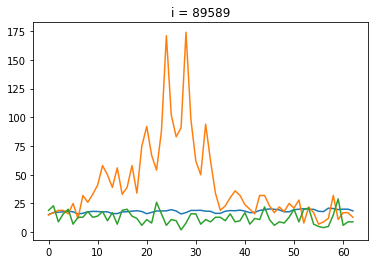

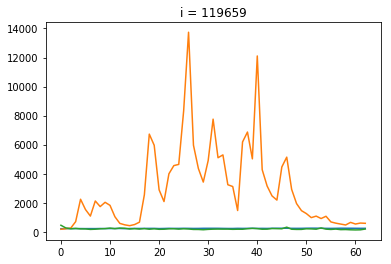

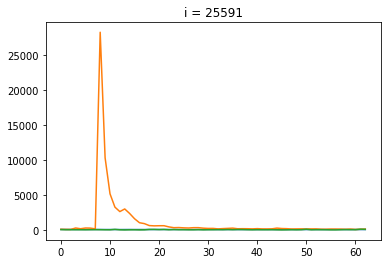

In [141]:
if test_length: examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list_bad)
else:           examine_list((Y_input_pred_ori, Y_input_ori, X_input_ori), view_list=view_list_bad)

In [142]:
print(input_center[view_list_good].reshape(-1))
print(input_center[view_list_bad].reshape(-1))

[ 2.41664051  2.37014285  3.46775605  1.79934055  2.92544102]
[ 0.30103     2.09516935  1.63848926  2.72529894  1.90848502]


In [143]:
if test_length: print(output_gp[view_list_good], output_gp[view_list_bad])
else:           print(input_gp[view_list_good], input_gp[view_list_bad])

[3 3 3 2 3] [1 3 2 3 2]


In [144]:
gp_smape

[138.26705667901564,
 60.673947073835407,
 43.045945702179516,
 33.45657998408393,
 28.131851847862642,
 39.940782588889547]

In [145]:
gp_n

[2291, 22088, 41343, 78354, 927, 60]

#### Case 93175

In [146]:
i = 93175

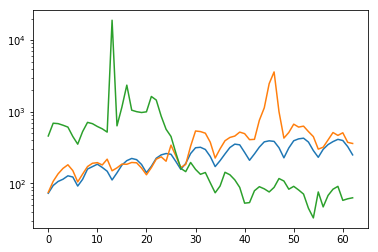

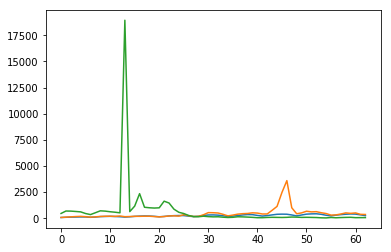

In [147]:
if test_length: 
    multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
    multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))
else:
    multi_view((Y_input_pred_ori[i], Y_input_ori[i], X_input_ori[i]), yscale='log')
    multi_view((Y_input_pred_ori[i], Y_input_ori[i], X_input_ori[i]))

In [148]:
if test_length: print(smape(Y_output_pred_ori[i], Y_output_raw[i]))
else:           print(smape(Y_input_pred_ori[i], Y_input_raw[i]))

33.2122750215


In [149]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 2.41664051]),
 array([ 2.41664051]),
 array([ 0.53988248]),
 array([ 0.51197664]))

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### SMAPE Distribution Investigation

#### SMAPE of the model for each data

In [150]:
if test_length:
    smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
                                in zip(Y_output_pred_ori, Y_output_raw)])
    smape_Y_pred = np.nan_to_num(smape_Y_pred_na)

In [151]:
if test_length:
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

In [152]:
if test_length:
    smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]

In [153]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

In [154]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [155]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [156]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [157]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

#### SMAPE for Fibonacci median

What if we replace the group 1 prediction by fib median

In [158]:
Y_output_fib_list = [fib_median[output_gp == gp].reshape(-1,1) 
                     for gp in gp_list]

In [159]:
Y_output_fib_list[1]

array([[ 4. ],
       [ 8.5],
       [ 4. ],
       ..., 
       [ 2. ],
       [ 5.5],
       [ 2. ]])

In [160]:
# The actual score with nan
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]
    print('Model|', 'Fib|', 'number in the group')
    print('-|-|-')
    for score1, score2, n in zip(gp_smape, gp_smape_fib, gp_n):
        print('%3.3f |'%score1, '%3.3f|'%score2, n)

In [161]:
model_name

'model_8_ANN_with_Fibonacci_1_meas_absolute_error-prediction'

See distribution result in '../results/self testing SMAPE distributions.txt'

#### model_8_ANN_with_Fibonacci_1_meas_absolute_error 4
Model| Fib| number in the group
-|-|-
149.236 | 115.887| 3422
63.983 | 61.823| 23105
44.329 | 45.496| 40264
36.418 | 40.368| 77416
38.309 | 40.033| 790
28.892 | 33.144| 66

#### model_8_ANN_with_Fibonacci_1_meas_absolute_error 3
Model| Fib| number in the group
-|-|-
160.358 | 115.887| 3422
64.593 | 61.823| 23105
44.417 | 45.496| 40264
36.413 | 40.368| 77416
39.466 | 40.033| 790
31.671 | 33.144| 66

#### model_8_ANN_with_Fibonacci_1_meas_absolute_error 2
Model| Fib| number in the group
-|-|-
165.458 | 115.887| 3422
64.139 | 61.823| 23105
44.523 | 45.496| 40264
36.138 | 40.368| 77416
38.813 | 40.033| 790
31.270 | 33.144| 66

#### model_8_ANN_with_Fibonacci_1_meas_absolute_error 1
Model| Fib| number in the group
-|-|-
154.479 | 115.887| 3422
63.987 | 61.823| 23105
44.428 | 45.496| 40264
36.033 | 40.368| 77416
39.607 | 40.033| 790
30.633 | 33.144| 66

# **Fib do better in group 0 and 1!!!**

#### SMAPE distribution for Fib

In [162]:
if test_length:
    smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
                               in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(smape_Y_fib_na)

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

In [163]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

In [164]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [165]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

In [166]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [167]:
Y_output_fib.shape

(145063, 1)

In [168]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [169]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [170]:
# The combined result
Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori

In [171]:
Y_output_fmc_ori

array([[ 24.99366168,  24.65899037,  24.70293772, ...,  22.57826336,
         22.82214717,  23.24424502],
       [ 18.72651096,  19.12811468,  19.24485791, ...,  18.89604219,
         19.09358426,  19.71464101],
       [  4.        ,   4.        ,   4.        , ...,   4.        ,
          4.        ,   4.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

#### Combined SMAPE Score

In [172]:
if test_length: 
    model_combined_smape_score = smape(Y_output_fmc_ori, Y_output_raw)
    print('Combined SMAPE and (CNN only):', '%6.3f' % model_combined_smape_score, '(%6.3f)' % model_smape_score)

In [173]:
model_name

'model_8_ANN_with_Fibonacci_1_meas_absolute_error-prediction'

See '../results/self testing SMAPE scores.txt' for historical SMAPE scores.

#### Combined Scores:
43.371 (44.061) - Model 8.1.0 - model_8_ANN_with_Fibonacci_1_meas_absolute_error 4

43.401 (44.304) - Model 8.1.0 - model_8_ANN_with_Fibonacci_1_meas_absolute_error 3

43.276 (44.167) - Model 8.1.0 - model_8_ANN_with_Fibonacci_1_meas_absolute_error 2

43.196 (43.944) - Model 8.1.0 - model_8_ANN_with_Fibonacci_1_meas_absolute_error 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool

44.835 (45.961) - Model 7.6.0 - model_7_CNN_with_Fibonacci_6_Wider_0_conv_120 1

44.713 (45.947) - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial 2

44.433          - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial 1

44.168          - Model 7.2.0

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [174]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [175]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_pred_ori, columns = Y_output_dates)
result_df

2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
0        24.993662   24.658990   24.702938   26.328956   24.431097   
1        18.726511   19.128115   19.244858   20.366256   19.443833   
2         4.337497    4.908440    5.192975    5.690908    5.080002   
3        15.241061   14.504762   14.290394   14.829334   14.073455   
4         7.756619    8.176254    8.222713    8.723774    8.367624   
5        34.112144   26.730989   25.084633   26.116228   24.015565   
6         7.508270    7.932653    8.182009    8.514598    8.049117   
7        44.762911   37.423302   36.289320   38.466099   35.885438   
8        49.029052   41.275549   39.682836   40.744217   37.853534   
9        39.077634   46.832944   48.078939   51.560051   49.023461   
10       31.169152   24.968938   23.773386   25.299072   22.977465   
11       15.032683   15.315064   15.531344   16.876302   15.589898   
12        3.445438    3.920716    4.019870    4.172891    3.932249   
13       13.489395   14.877740   15.032251   15.909210   15.363939   
14       53.284312   52.656769   51.955018   53.422994   50.253928   
15       31.200246   33.206797   33.808383   35.833081   33.784951   
16       29.793599   30.027403   30.814121   33.003442   30.425573   
17        9.401888    9.693649    9.687515    9.760138    9.573717   
18       12.152485   13.315021   13.683195   14.485396   13.979463   
19        7.688164    7.900534    7.991336    8.250555    7.757977   
20       29.956173   40.206113   41.898694   47.431001   44.671682   
21       19.579205   19.337496   19.376609   19.976188   19.396426   
22       24.292067   27.398648   27.970212   30.196618   27.880294   
23       34.911983   35.137610   35.349329   37.038196   35.015399   
24       65.239323   67.902529   66.870726   71.353740   66.902817   
25       17.139122   15.997231   15.562167   15.839486   15.120137   
26       42.536357   51.607961   53.096261   57.881541   54.211140   
27       10.173696   10.586643   10.722938   11.323860   10.950841   
28       35.636806   33.974526   32.880463   33.222469   31.491595   
29       12.838729   12.110359   11.561951   11.607799   10.693016   
...            ...         ...         ...         ...         ...   
145033   39.282967   37.935460   37.491274   38.932688   36.275319   
145034    5.760953    5.768544    5.775824    6.932546    6.278489   
145035   13.031466   14.079344   14.623809   15.928234   14.683431   
145036    1.474954    1.514006    1.485673    1.562724    1.426501   
145037    3.926092    4.453915    4.604250    4.960814    4.423961   
145038   14.395892   14.083845   14.085656   14.955587   14.013710   
145039   13.336453   16.473920   16.995342   19.077394   17.798546   
145040    2.532885    2.616729    2.624073    2.703898    2.595975   
145041    6.488917    7.026865    7.074854    7.500684    6.990936   
145042    4.121523    4.261216    4.472138    4.905383    4.348115   
145043    6.798099    7.077841    6.693871    7.423908    6.482610   
145044   22.065236   22.735942   23.441824   26.397704   22.856036   
145045    0.787888    0.802788    0.798988    0.821282    0.790697   
145046    7.222594    7.496973    7.558876    7.916662    7.662508   
145047    5.167031    5.614929    5.728432    6.239262    5.708074   
145048    3.896028    4.977577    5.522427    6.226383    5.268893   
145049    9.883878   10.919358   11.802752   13.092786   11.342362   
145050    5.626128    6.318204    6.366216    6.428537    5.613817   
145051    9.656152    9.771888   11.926911   15.097633   13.723943   
145052    7.707196    7.189172    7.302841    8.169118    7.446351   
145053   10.676355   12.257210   13.272910   14.718325   12.966382   
145054   12.407023   11.172196   10.898939   12.402188   10.728141   
145055    1.751398    2.193826    2.604985    2.965065    2.308329   
145056    3.382166    3.149114    3.348866    3.665070    3.550403   
145057    0.000073    0.000030    0.000037    0.000017    0.000092   
145058    9.605407

In [176]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
0        24.993662   24.658990   24.702938   26.328956   24.431097   
1        18.726511   19.128115   19.244858   20.366256   19.443833   
2         4.337497    4.908440    5.192975    5.690908    5.080002   
3        15.241061   14.504762   14.290394   14.829334   14.073455   
4         7.756619    8.176254    8.222713    8.723774    8.367624   
5        34.112144   26.730989   25.084633   26.116228   24.015565   
6         7.508270    7.932653    8.182009    8.514598    8.049117   
7        44.762911   37.423302   36.289320   38.466099   35.885438   
8        49.029052   41.275549   39.682836   40.744217   37.853534   
9        39.077634   46.832944   48.078939   51.560051   49.023461   
10       31.169152   24.968938   23.773386   25.299072   22.977465   
11       15.032683   15.315064   15.531344   16.876302   15.589898   
12        3.445438    3.920716    4.019870    4.172891    3.932249   
13       13.489395   14.877740   15.032251   15.909210   15.363939   
14       53.284312   52.656769   51.955018   53.422994   50.253928   
15       31.200246   33.206797   33.808383   35.833081   33.784951   
16       29.793599   30.027403   30.814121   33.003442   30.425573   
17        9.401888    9.693649    9.687515    9.760138    9.573717   
18       12.152485   13.315021   13.683195   14.485396   13.979463   
19        7.688164    7.900534    7.991336    8.250555    7.757977   
20       29.956173   40.206113   41.898694   47.431001   44.671682   
21       19.579205   19.337496   19.376609   19.976188   19.396426   
22       24.292067   27.398648   27.970212   30.196618   27.880294   
23       34.911983   35.137610   35.349329   37.038196   35.015399   
24       65.239323   67.902529   66.870726   71.353740   66.902817   
25       17.139122   15.997231   15.562167   15.839486   15.120137   
26       42.536357   51.607961   53.096261   57.881541   54.211140   
27       10.173696   10.586643   10.722938   11.323860   10.950841   
28       35.636806   33.974526   32.880463   33.222469   31.491595   
29       12.838729   12.110359   11.561951   11.607799   10.693016   
...            ...         ...         ...         ...         ...   
145033   39.282967   37.935460   37.491274   38.932688   36.275319   
145034    5.760953    5.768544    5.775824    6.932546    6.278489   
145035   13.031466   14.079344   14.623809   15.928234   14.683431   
145036    1.474954    1.514006    1.485673    1.562724    1.426501   
145037    3.926092    4.453915    4.604250    4.960814    4.423961   
145038   14.395892   14.083845   14.085656   14.955587   14.013710   
145039   13.336453   16.473920   16.995342   19.077394   17.798546   
145040    2.532885    2.616729    2.624073    2.703898    2.595975   
145041    6.488917    7.026865    7.074854    7.500684    6.990936   
145042    4.121523    4.261216    4.472138    4.905383    4.348115   
145043    6.798099    7.077841    6.693871    7.423908    6.482610   
145044   22.065236   22.735942   23.441824   26.397704   22.856036   
145045    0.787888    0.802788    0.798988    0.821282    0.790697   
145046    7.222594    7.496973    7.558876    7.916662    7.662508   
145047    5.167031    5.614929    5.728432    6.239262    5.708074   
145048    3.896028    4.977577    5.522427    6.226383    5.268893   
145049    9.883878   10.919358   11.802752   13.092786   11.342362   
145050    5.626128    6.318204    6.366216    6.428537    5.613817   
145051    9.656152    9.771888   11.926911   15.097633   13.723943   
145052    7.707196    7.189172    7.302841    8.169118    7.446351   
145053   10.676355   12.257210   13.272910   14.718325   12.966382   
145054   12.407023   11.172196   10.898939   12.402188   10.728141   
145055    1.751398    2.193826    2.604985    2.965065    2.308329   
145056    3.382166    3.149114    3.348866    3.665070    3.550403   
145057    0.000073    0.000030    0.000037    0.000017    0.000092   
145058    9.605407

In [177]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

Page        date  \
0                  2NE1_zh.wikipedia.org_all-access_spider  2017-01-01   
1                   2PM_zh.wikipedia.org_all-access_spider  2017-01-01   
2                    3C_zh.wikipedia.org_all-access_spider  2017-01-01   
3               4minute_zh.wikipedia.org_all-access_spider  2017-01-01   
4        52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  2017-01-01   
5                  5566_zh.wikipedia.org_all-access_spider  2017-01-01   
6                91Days_zh.wikipedia.org_all-access_spider  2017-01-01   
7                 A'N'D_zh.wikipedia.org_all-access_spider  2017-01-01   
8                 AKB48_zh.wikipedia.org_all-access_spider  2017-01-01   
9                 ASCII_zh.wikipedia.org_all-access_spider  2017-01-01   
10                ASTRO_zh.wikipedia.org_all-access_spider  2017-01-01   
11       Ahq_e-Sports_Club_zh.wikipedia.org_all-access_...  2017-01-01   
12       All_your_base_are_belong_to_us_zh.wikipedia.or...  2017-01-01   
13              AlphaGo_zh.wikipedia.org_all-access_spider  2017-01-01   
14              Android_zh.wikipedia.org_all-access_spider  2017-01-01   
15           Angelababy_zh.wikipedia.org_all-access_spider  2017-01-01   
16                Apink_zh.wikipedia.org_all-access_spider  2017-01-01   
17             Apple_II_zh.wikipedia.org_all-access_spider  2017-01-01   
18               As_One_zh.wikipedia.org_all-access_spider  2017-01-01   
19            B-PROJECT_zh.wikipedia.org_all-access_spider  2017-01-01   
20                 B1A4_zh.wikipedia.org_all-access_spider  2017-01-01   
21                 BDSM_zh.wikipedia.org_all-access_spider  2017-01-01   
22                BEAST_zh.wikipedia.org_all-access_spider  2017-01-01   
23              BIGBANG_zh.wikipedia.org_all-access_spider  2017-01-01   
24           BLACK_PINK_zh.wikipedia.org_all-access_spider  2017-01-01   
25               BLEACH_zh.wikipedia.org_all-access_spider  2017-01-01   
26                 BTOB_zh.wikipedia.org_all-access_spider  2017-01-01   
27       Beautiful_Mind_zh.wikipedia.org_all-access_spider  2017-01-01   
28               Beyond_zh.wikipedia.org_all-access_spider  2017-01-01   
29                  Big_zh.wikipedia.org_all-access_spider  2017-01-01   
...                                                    ...         ...   
9138939  Sin_senos_sí_hay_paraíso_es.wikipedia.org_all-...  2017-03-04   
9138940  Anexo:Medallero_de_los_Juegos_Olímpicos_de_Río...  2017-03-04   
9138941  Arrival_(película)_es.wikipedia.org_all-access...  2017-03-04   
9138942  Anexo:Baloncesto_en_los_Juegos_Olímpicos_de_Rí...  2017-03-04   
9138943  Hasta_que_te_conocí_(serie_de_televisión)_es.w...  2017-03-04   
9138944  Westworld_(serie_de_televisión)_es.wikipedia.o...  2017-03-04   
9138945        Milénico_es.wikipedia.org_all-access_spider  2017-03-04   
9138946  Moonlight_(película)_es.wikipedia.org_all-acce...  2017-03-04   
9138947  Sully_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138948  Pulsaciones_(serie_de_televisión)_es.wikipedia...  2017-03-04   
9138949  2091_(serie_de_televisión)_es.wikipedia.org_al...  2017-03-04   
9138950  Campeonato_Sudamericano_de_Fútbol_Sub-20_de_20...  2017-03-04   
9138951  Split_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138952  Huracán_Matthew_es.wikipedia.org_all-access_sp...  2017-03-04   
9138953  Fences_(película)_es.wikipedia.org_all-access_...  2017-03-04   
9138954  Logan_(película)_es.wikipedia.org_all-access_s...  2017-03-04   
9138955  La_doña_(telenovela_de_2016)_es.wikipedia.org_...  2017-03-04   
9138956  RTS_(canal_de_televisión)_es.wikipedia.org_all...  2017-03-04   
9138957  La_ley_del_corazón_es.wikipedia.org_all-access...  2017-03-04   
9138958  The_Crown_(serie_de_televisión)_es.wikipedia.o...  2017-03-04   
9138959  Drake_(músico)_es.wikipedia.org_all-access_spider  2017-03-04   
9138960  Skam_(serie_de_televisión)_es.wikipedia.org_al...  2017-03-04   
9138961  Legión_(serie_de_televisión)_es.wikipedia.org_...

### Output DataFrame

In [178]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

%%% Reading data key_1.csv ...done!


In [179]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

Page            Id        date
0  !vote_en.wikipedia.org_all-access_all-agents  bf4edcf969af  2017-01-01
1  !vote_en.wikipedia.org_all-access_all-agents  929ed2bf52b9  2017-01-02
2  !vote_en.wikipedia.org_all-access_all-agents  ff29d0f51d5c  2017-01-03
3  !vote_en.wikipedia.org_all-access_all-agents  e98873359be6  2017-01-04
4  !vote_en.wikipedia.org_all-access_all-agents  fa012434263a  2017-01-05

In [180]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703780 entries, 0 to 8703779
Data columns (total 3 columns):
Page    object
Id      object
date    object
dtypes: object(3)
memory usage: 199.2+ MB


In [181]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

array(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
       '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
       '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
       '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
       '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
       '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
       '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
       '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
       '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
       '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
       '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
       '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
       '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-01-01', '2017-01-02'], dtype=object)

In [182]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [183]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

Page            Id  \
0        !vote_en.wikipedia.org_all-access_all-agents  bf4edcf969af   
1        !vote_en.wikipedia.org_all-access_all-agents  929ed2bf52b9   
2        !vote_en.wikipedia.org_all-access_all-agents  ff29d0f51d5c   
3        !vote_en.wikipedia.org_all-access_all-agents  e98873359be6   
4        !vote_en.wikipedia.org_all-access_all-agents  fa012434263a   
5        !vote_en.wikipedia.org_all-access_all-agents  48f1e93517a2   
6        !vote_en.wikipedia.org_all-access_all-agents  5def418fcb36   
7        !vote_en.wikipedia.org_all-access_all-agents  77bd08134351   
8        !vote_en.wikipedia.org_all-access_all-agents  5889e6dbb16f   
9        !vote_en.wikipedia.org_all-access_all-agents  5f21fef1d764   
10       !vote_en.wikipedia.org_all-access_all-agents  6f07e1b8815a   
11       !vote_en.wikipedia.org_all-access_all-agents  228e54b5dea0   
12       !vote_en.wikipedia.org_all-access_all-agents  da1b34963ed7   
13       !vote_en.wikipedia.org_all-access_all-agents  ab5ccefaa2db   
14       !vote_en.wikipedia.org_all-access_all-agents  cbf42873ebf1   
15       !vote_en.wikipedia.org_all-access_all-agents  ac67e35ed44e   
16       !vote_en.wikipedia.org_all-access_all-agents  88c098aa640d   
17       !vote_en.wikipedia.org_all-access_all-agents  7c72842a89d1   
18       !vote_en.wikipedia.org_all-access_all-agents  8ce002f2c329   
19       !vote_en.wikipedia.org_all-access_all-agents  5f72d9920560   
20       !vote_en.wikipedia.org_all-access_all-agents  f93afd7f5d9b   
21       !vote_en.wikipedia.org_all-access_all-agents  14011cb66f2d   
22       !vote_en.wikipedia.org_all-access_all-agents  0065551ac465   
23       !vote_en.wikipedia.org_all-access_all-agents  175f1872729e   
24       !vote_en.wikipedia.org_all-access_all-agents  31d756e83124   
25       !vote_en.wikipedia.org_all-access_all-agents  e186c2363c5e   
26       !vote_en.wikipedia.org_all-access_all-agents  3bce56c2b977   
27       !vote_en.wikipedia.org_all-access_all-agents  d497981dce77   
28       !vote_en.wikipedia.org_all-access_all-agents  c813cec10548   
29       !vote_en.wikipedia.org_all-access_all-agents  5123e0ed62c9   
...                                               ...           ...   
8703750   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1fb8f902ad0f   
8703751   龙生九子_zh.wikipedia.org_mobile-web_all-agents  0107f6d7cd82   
8703752   龙生九子_zh.wikipedia.org_mobile-web_all-agents  30c402ed9e49   
8703753   龙生九子_zh.wikipedia.org_mobile-web_all-agents  935fa0168d01   
8703754   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1140b428380e   
8703755   龙生九子_zh.wikipedia.org_mobile-web_all-agents  cc5eadae0d7a   
8703756   龙生九子_zh.wikipedia.org_mobile-web_all-agents  f923701cdb05   
8703757   龙生九子_zh.wikipedia.org_mobile-web_all-agents  905679a20d39   
8703758   龙生九子_zh.wikipedia.org_mobile-web_all-agents  642354a50690   
8703759   龙生九子_zh.wikipedia.org_mobile-web_all-agents  7376c63bd4c1   
8703760   龙生九子_zh.wikipedia.org_mobile-web_all-agents  1f0566b71f7e   
8703761   龙生九子_zh.wikipedia.org_mobile-web_all-agents  938774bbb675   
8703762   龙生九子_zh.wikipedia.org_mobile-web_all-agents  53c046bac8cb   
8703763   龙生九子_zh.wikipedia.org_mobile-web_all-agents  ead2377353d3   
8703764   龙生九子_zh.wikipedia.org_mobile-web_all-agents  efa87c7d5160   
8703765   龙生九子_zh.wikipedia.org_mobile-web_all-agents  f239d6ceb17b   
8703766   龙生九子_zh.wikipedia.org_mobile-web_all-agents  0fef0826b1bc   
8703767   龙生九子_zh.wikipedia.org_mobile-web_all-agents  478d3c34b0c1   
8703768   龙生九子_zh.wikipedia.org_mobile-web_all-agents  6a1b6e3028fc   
8703769   龙生九子_zh.wikipedia.org_mobile-web_all-agents  3b5fb022accd   
8703770   龙生九子_zh.wikipedia.org_mobile-web_all-agents  a4456a9d271d   
8703771   龙生九子_zh.wikipedia.org_mobile-web_all-agents  d43a25cf4ef2   
8703772   龙生九子_zh.wikipedia.org_mobile-web_all-agents  8f47d2e020cd   
8703773   龙生九子_zh.wikipedia.org_mobile-web_all-agents  a78af728d84b   
8703774   龙生九子_zh.wikipedia.org_mobile-web_all-agents  d1ba45c7ec08   
87

In [184]:
del result_flat_df

In [185]:
gc.collect()

45262

In [186]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

Series([], Name: Visits, dtype: float64)

In [187]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [188]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

%%% Writing result for model_8_ANN_with_Fibonacci_1_meas_absolute_error-prediction ...done!


Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]